# Exploring Text Classification Datasets (AGNews, DBPedia, IMDb, Amazon)

This notebook explores each of the main datasets used in the KeyClass implementation:

- AGNEWS: classification of news topics.
- DBPedia: classification of wikipedia categories.
- IMDb: classification of movie reviews.
- Amazon: classification of amazon reviews.

All datasets are used for single-label multiclass text classification benchmarking.

We will examine:
1.  Dataset size and train/test split distribution.
2.  Distribution of records per category.
4.  Statistics on the length of each record in the train/test splits (min, max, average, mean).
5.  Category distribution comparison between train/test sets.

## 1. Setup and Data Loading

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# --- Configuration ---
DATA_DIR = 'original_data'  # Folder containing the datasets
DATASET_NAMES = ['AGNews', 'DBPedia', 'IMDb', 'Amazon']

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6) # Default figure size
plt.rcParams.update({'font.size': 10, 'axes.titlesize': 12, 'axes.labelsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'legend.fontsize': 10})

In [3]:
def load_dataset_from_folder(dataset_name, base_dir):
    """Loads text and labels for train/test sets for a given dataset from folders."""
    dataset_folder_name = dataset_name.lower()
    print(f"Loading dataset: {dataset_name}...")
    dataset_path = os.path.join(base_dir, dataset_folder_name)

    # Define file paths
    label_names_file = os.path.join(dataset_path, 'label_names.txt')
    train_texts_file = os.path.join(dataset_path, 'train.txt')
    train_labels_file = os.path.join(dataset_path, 'train_labels.txt')
    test_texts_file = os.path.join(dataset_path, 'test.txt')
    test_labels_file = os.path.join(dataset_path, 'test_labels.txt')

    required_files = [label_names_file, train_texts_file, train_labels_file, test_texts_file, test_labels_file]

    # Check if all required files exist
    missing_files = [f for f in required_files if not os.path.exists(f)]
    if missing_files:
        print(f"  - Error: Missing required files for dataset '{dataset_name}': {', '.join(missing_files)}")
        print("-" * 30)
        return None, None, None

    try:
        # --- Load Label Names ---
        with open(label_names_file, 'r', encoding='utf-8') as f:
            label_names = [line.strip() for line in f if line.strip()]
        print(f"  - Found {len(label_names)} classes: {', '.join(label_names)}")

        # --- Load Train Data ---
        with open(train_texts_file, 'r', encoding='utf-8') as f:
            train_texts = [line.strip() for line in f]
        with open(train_labels_file, 'r', encoding='utf-8') as f:
            train_labels_idx = [int(line.strip()) for line in f]

        # --- Load Test Data ---
        with open(test_texts_file, 'r', encoding='utf-8') as f:
            test_texts = [line.strip() for line in f]
        with open(test_labels_file, 'r', encoding='utf-8') as f:
            test_labels_idx = [int(line.strip()) for line in f]

        # --- Create DataFrames ---
        df_train = pd.DataFrame({'text': train_texts, 'label_index': train_labels_idx})
        df_test = pd.DataFrame({'text': test_texts, 'label_index': test_labels_idx})

        # --- Map Label Indices to Names ---
        max_label_index = len(label_names) - 1
        df_train['label_name'] = df_train['label_index'].apply(lambda x: label_names[x] if 0 <= x <= max_label_index else 'Unknown')
        df_test['label_name'] = df_test['label_index'].apply(lambda x: label_names[x] if 0 <= x <= max_label_index else 'Unknown')

        print(f"  - Loaded {len(df_train)} training samples and {len(df_test)} testing samples.")
        print("-" * 30)
        return df_train, df_test, label_names

    except FileNotFoundError as e:
         print(f"  - Error loading file: {e}. File might be missing in the directory '{dataset_path}'.")
         print("-" * 30)
         return None, None, None
    except ValueError as e:
         print(f"  - Error converting label to integer in '{dataset_name}'. Check label files for non-numeric content: {e}")
         print("-" * 30)
         return None, None, None
    except Exception as e:
        print(f"  - An unexpected error occurred while loading dataset '{dataset_name}': {e}")
        print("-" * 30)
        return None, None, None


# --- Main Loading Process ---
datasets_data = {}
if not os.path.isdir(DATA_DIR):
    print(f"Error: Data directory not found at '{DATA_DIR}'")
else:
    print(f"Looking for datasets in: '{DATA_DIR}'")
    for name in DATASET_NAMES:
        dataset_path = os.path.join(DATA_DIR, name.lower())
        if os.path.isdir(dataset_path):
             df_train, df_test, label_names = load_dataset_from_folder(name, DATA_DIR)
             if df_train is not None and df_test is not None:
                 datasets_data[name] = {'train': df_train, 'test': df_test, 'labels': label_names}
        else:
             print(f"Dataset directory '{dataset_path}' not found.")
             print("-" * 30)

# Check if any data was loaded
if not datasets_data:
    print("\nNo datasets were successfully loaded. Please check the data directory path and its contents.")
else:
    print(f"\nSuccessfully loaded data for: {', '.join(datasets_data.keys())}")

Looking for datasets in: 'original_data'
Loading dataset: AGNews...
  - Found 4 classes: politics, sports, business, technology
  - Loaded 120000 training samples and 7600 testing samples.
------------------------------
Loading dataset: DBPedia...
  - Found 14 classes: company, school university, artist, athlete, politics, transportation, building, river mountain lake, village, animal, plant tree, album, film, novel publication book
  - Loaded 560000 training samples and 70000 testing samples.
------------------------------
Loading dataset: IMDb...
  - Found 2 classes: bad, good
  - Loaded 25000 training samples and 25000 testing samples.
------------------------------
Loading dataset: Amazon...
  - Found 2 classes: bad, good
  - Loaded 3600000 training samples and 400000 testing samples.
------------------------------

Successfully loaded data for: AGNews, DBPedia, IMDb, Amazon


## 2. Dataset Sizes and Train/Test Splits

Let's analyze the total number of records and how they are distributed between the training and testing sets.

In [4]:
split_data = []
for name, data in datasets_data.items():
    n_train = len(data['train'])
    n_test = len(data['test'])
    n_total = n_train + n_test
    train_perc = (n_train / n_total) * 100 if n_total > 0 else 0
    test_perc = (n_test / n_total) * 100 if n_total > 0 else 0

    print(f"\nDataset: {name}")
    print("-" * 30)
    print(f"Total records: {n_total}")
    print(f"Training records: {n_train} ({train_perc:.2f}%)")
    print(f"Testing records: {n_test} ({test_perc:.2f}%)")

    split_data.append({'Dataset': name, 'Set': 'Train', 'Count': n_train})
    split_data.append({'Dataset': name, 'Set': 'Test', 'Count': n_test})


Dataset: AGNews
------------------------------
Total records: 127600
Training records: 120000 (94.04%)
Testing records: 7600 (5.96%)

Dataset: DBPedia
------------------------------
Total records: 630000
Training records: 560000 (88.89%)
Testing records: 70000 (11.11%)

Dataset: IMDb
------------------------------
Total records: 50000
Training records: 25000 (50.00%)
Testing records: 25000 (50.00%)

Dataset: Amazon
------------------------------
Total records: 4000000
Training records: 3600000 (90.00%)
Testing records: 400000 (10.00%)


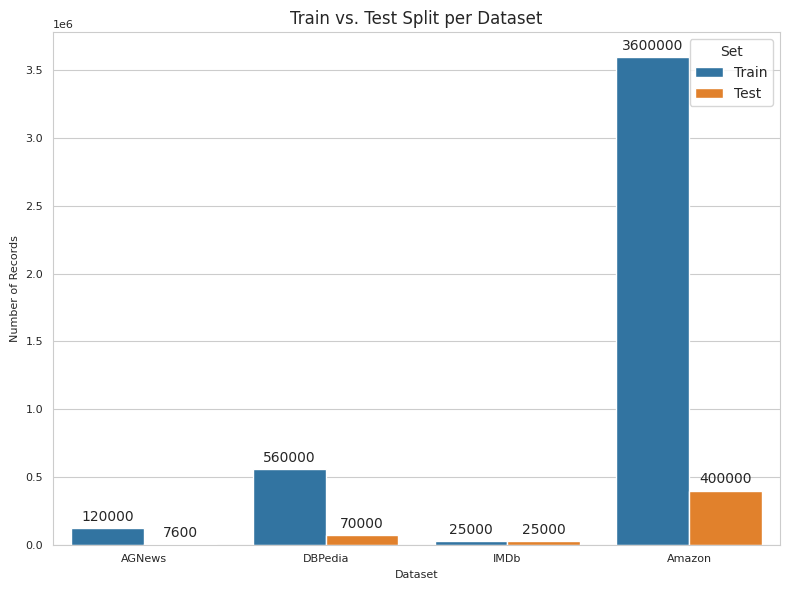

In [5]:
# Visualization for Splits
if split_data:
    plt.figure(figsize=(8, 6))
    split_df = pd.DataFrame(split_data)
    ax = sns.barplot(x='Dataset', y='Count', hue='Set', data=split_df)
    plt.title('Train vs. Test Split per Dataset')
    plt.ylabel('Number of Records')
    plt.xlabel('Dataset')
    plt.tight_layout()
    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)
    plt.show()

### 2.1 Observations

The number of samples in the test/train splits of each dataset **exactly matches** what is described in Table 2 (Dataset Statistics) of the KeyClass paper.

In addition, we can observe that the percentage distribution for each dataset is different, being approximately:
- AGNews: 94% train, 6% test.
- DBPedia: 89% train, 11% test.
- IMDb: 50% train, 50% test.
- Amazon: 90% train, 10% test.

## 3. Class Distribution Analysis (Train + Test splits)

Let's now check the sample distribution (train + test splits) for each classification category.


Dataset: AGNews
------------------------------
Class Counts & Proportions:
  - business: 31900 (25.00%)
  - politics: 31900 (25.00%)
  - sports: 31900 (25.00%)
  - technology: 31900 (25.00%)


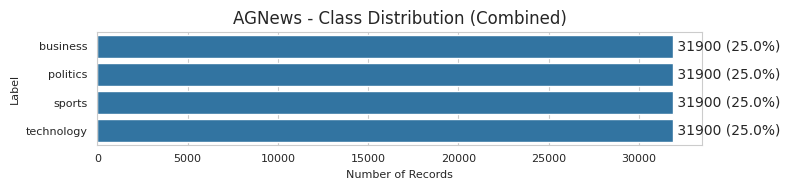


Dataset: DBPedia
------------------------------
Class Counts & Proportions:
  - album: 45000 (7.14%)
  - animal: 45000 (7.14%)
  - artist: 45000 (7.14%)
  - athlete: 45000 (7.14%)
  - building: 45000 (7.14%)
  - company: 45000 (7.14%)
  - film: 45000 (7.14%)
  - novel publication book: 45000 (7.14%)
  - plant tree: 45000 (7.14%)
  - politics: 45000 (7.14%)
  - river mountain lake: 45000 (7.14%)
  - school university: 45000 (7.14%)
  - transportation: 45000 (7.14%)
  - village: 45000 (7.14%)


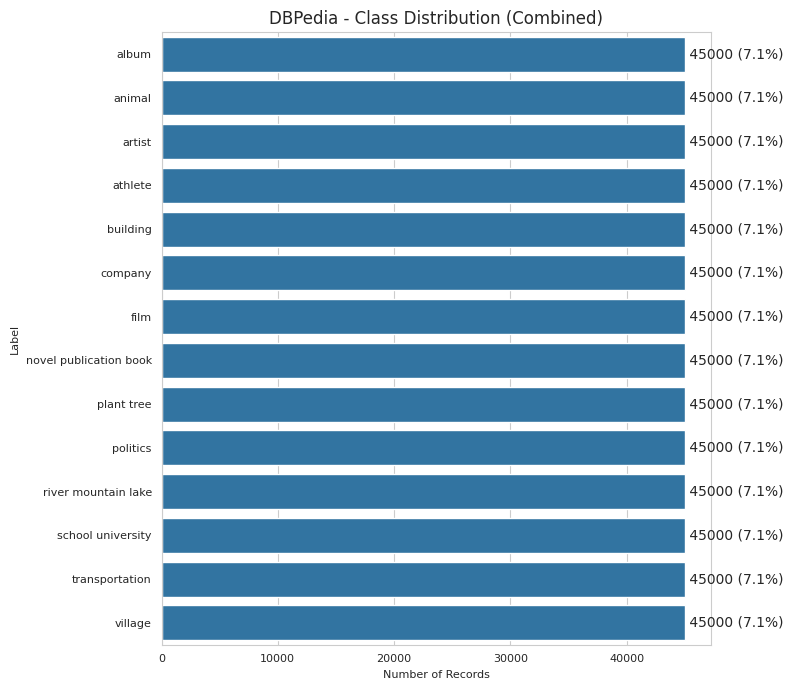


Dataset: IMDb
------------------------------
Class Counts & Proportions:
  - bad: 25000 (50.00%)
  - good: 25000 (50.00%)


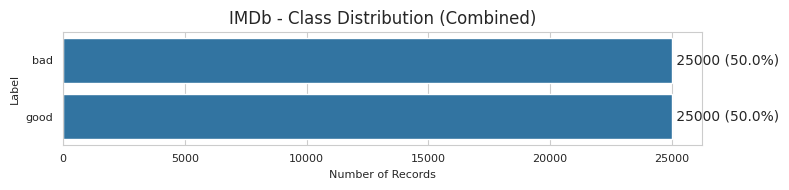


Dataset: Amazon
------------------------------
Class Counts & Proportions:
  - bad: 2000000 (50.00%)
  - good: 2000000 (50.00%)


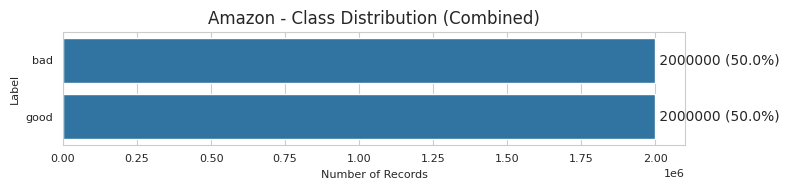

In [6]:
all_class_dist_data = []
for name, data in datasets_data.items():
    print(f"\nDataset: {name}")
    print("-" * 30)
    df_combined = pd.concat([data['train'], data['test']], ignore_index=True)
    n_total = len(df_combined)
    class_counts = df_combined['label_name'].value_counts().sort_index() # Sort by label name

    print("Class Counts & Proportions:")
    class_dist_list = []
    for label, count in class_counts.items():
        proportion = (count / n_total) * 100 if n_total > 0 else 0
        print(f"  - {label}: {count} ({proportion:.2f}%)")
        class_dist_list.append({'Dataset': name.upper(), 'Class': label, 'Count': count, 'Proportion': proportion})
    all_class_dist_data.extend(class_dist_list)

    # Visualization for Class Distribution (per dataset)
    plt.figure(figsize=(8, max(2, len(class_counts) * 0.5))) # Adjust height based on num classes
    sns.barplot(y=class_counts.index, x=class_counts.values, orient='h')
    plt.title(f'{name} - Class Distribution (Combined)')
    plt.xlabel('Number of Records')
    plt.ylabel('Label')
    # Add annotations
    for index, value in enumerate(class_counts.values):
        proportion = (value / n_total) * 100 if n_total > 0 else 0
        plt.text(value, index, f' {value} ({proportion:.1f}%)', va='center', ha='left') # Align text left for h-bar
    plt.tight_layout()
    plt.show()

### 3.1 Observations

We can observe that the four datasets are balanced, just like described on Table 2 (Dataset Statistics) of the KeyClass paper.

## 4. Text Length Analysis (Characters)

In this section, we will analyze the text length (number of characters) of each sample for the four datasets.

In [12]:
length_stats = []
all_lengths = []
for name, data in datasets_data.items():
    df_combined = pd.concat([data['train'], data['test']], ignore_index=True)
    df_combined['text'] = df_combined['text'].astype(str) # Ensure string type
    df_combined['TextLength'] = df_combined['text'].apply(len)

    min_len = df_combined['TextLength'].min()
    max_len = df_combined['TextLength'].max()
    avg_len = df_combined['TextLength'].mean()
    median_len = df_combined['TextLength'].median()

    # Store for combined visualization
    length_stats.append({
        'Dataset': name, 'Min': min_len, 'Max': max_len,
        'Mean': avg_len, 'Median': median_len
    })
    # Add individual lengths for boxplot
    all_lengths.extend([(name, length) for length in df_combined['TextLength']])

print("Text Length Analysis (Number of Characters per Sample)")
print("-" * 80) 
length_stats_df = pd.DataFrame(length_stats)
length_stats_df['Mean'] = length_stats_df['Mean'].round(2)
length_stats_df['Median'] = length_stats_df['Median'].round(2)
print(length_stats_df.to_string(index=False))

Text Length Analysis (Number of Characters per Sample)
--------------------------------------------------------------------------------
Dataset  Min   Max    Mean  Median
 AGNews   99  1024  237.58   233.0
DBPedia   12 13586  303.25   304.0
   IMDb   32 13593 1290.45   957.0
 Amazon   72  1085  431.69   383.0


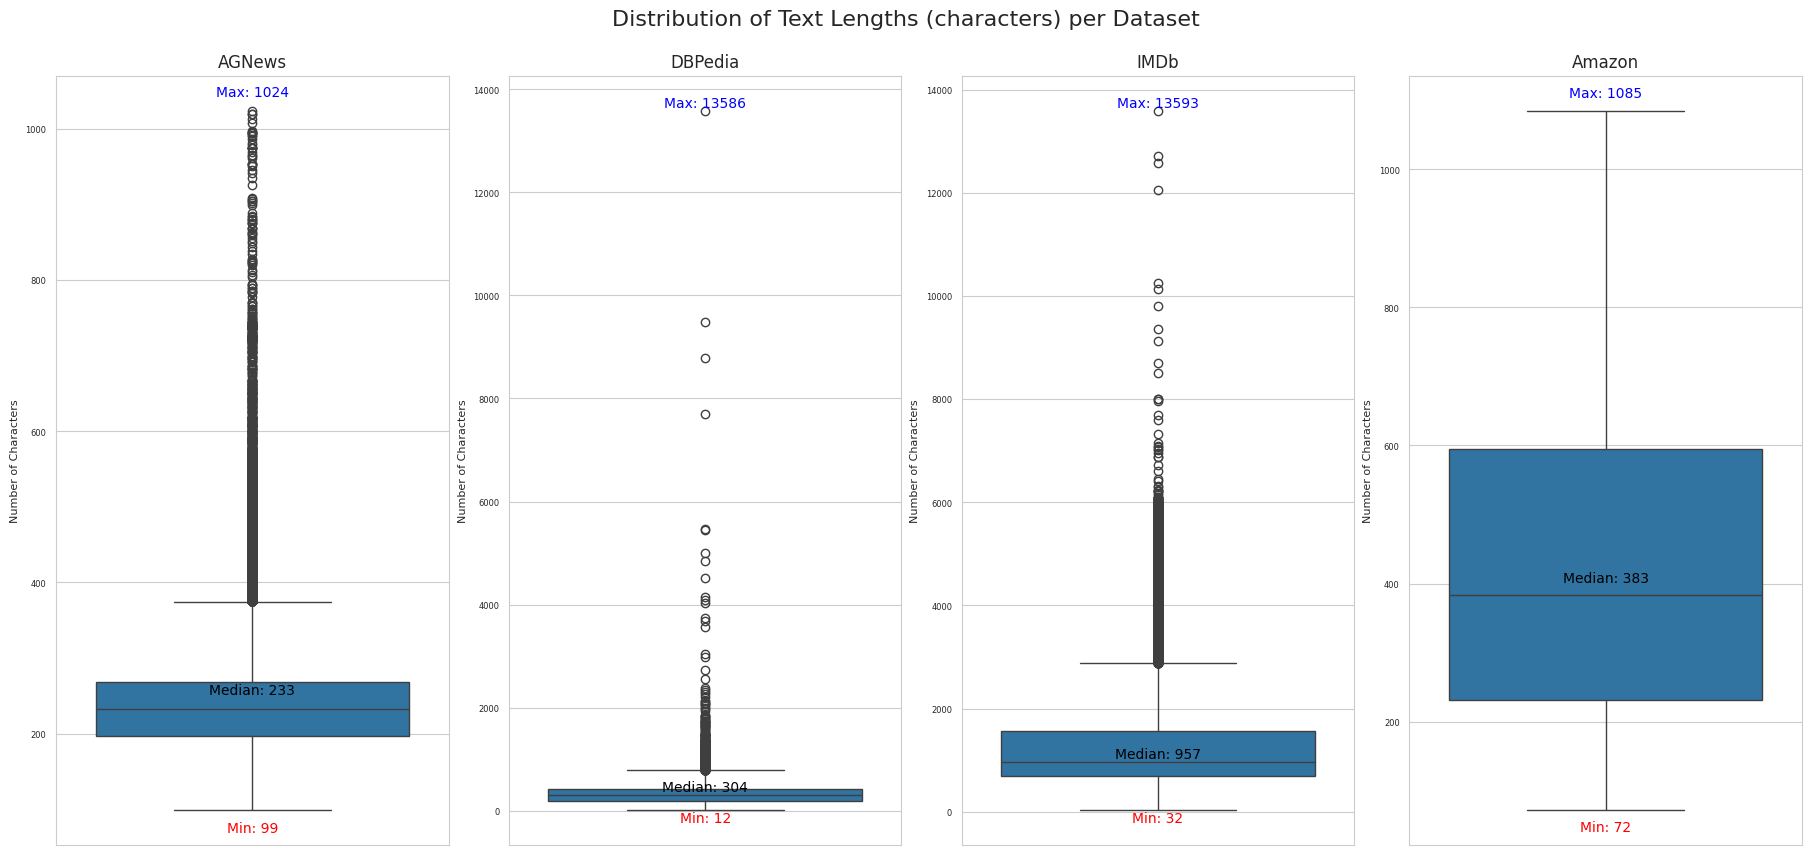

In [15]:
length_df = pd.DataFrame(all_lengths, columns=['Dataset', 'TextLength'])
datasets = length_df['Dataset'].unique() 
fig, axes = plt.subplots(nrows=1, ncols=len(datasets), figsize=(18, 8), 
        sharey=False, constrained_layout=True)

for ax, ds in zip(axes, datasets):
    slice_ = length_df.query("Dataset == @ds")           # filter once per dataset
    sns.boxplot(data=slice_, y='TextLength', ax=ax,  orient='v', showfliers=True)
    ax.set_title(ds)               
    ax.set_ylabel("Number of Characters")   

    values = length_df[length_df['Dataset'] == ds]['TextLength']
    min_val = values.min()
    median_val = values.median()
    max_val = values.max()
    # Add labels for max, min, median
    ax.text(0, min_val-15, f'Min: {min_val:.0f}', ha='center', va='top', fontsize=10, color='red')
    ax.text(0, median_val+15, f'Median: {median_val:.0f}', ha='center', va='bottom', fontsize=10, color='black')
    ax.text(0, max_val+15, f'Max: {max_val:.0f}', ha='center', va='bottom', fontsize=10, color='blue')
    
    ax.tick_params(axis='both', labelsize=6)

fig.suptitle("Distribution of Text Lengths (characters) per Dataset", y=1.05, fontsize=16)
plt.show()

## 5. Class Distribution Comparison (Train vs. Test Splits)

Ideally, the proportions for each classification class/category should be very similar between the train/test splits.

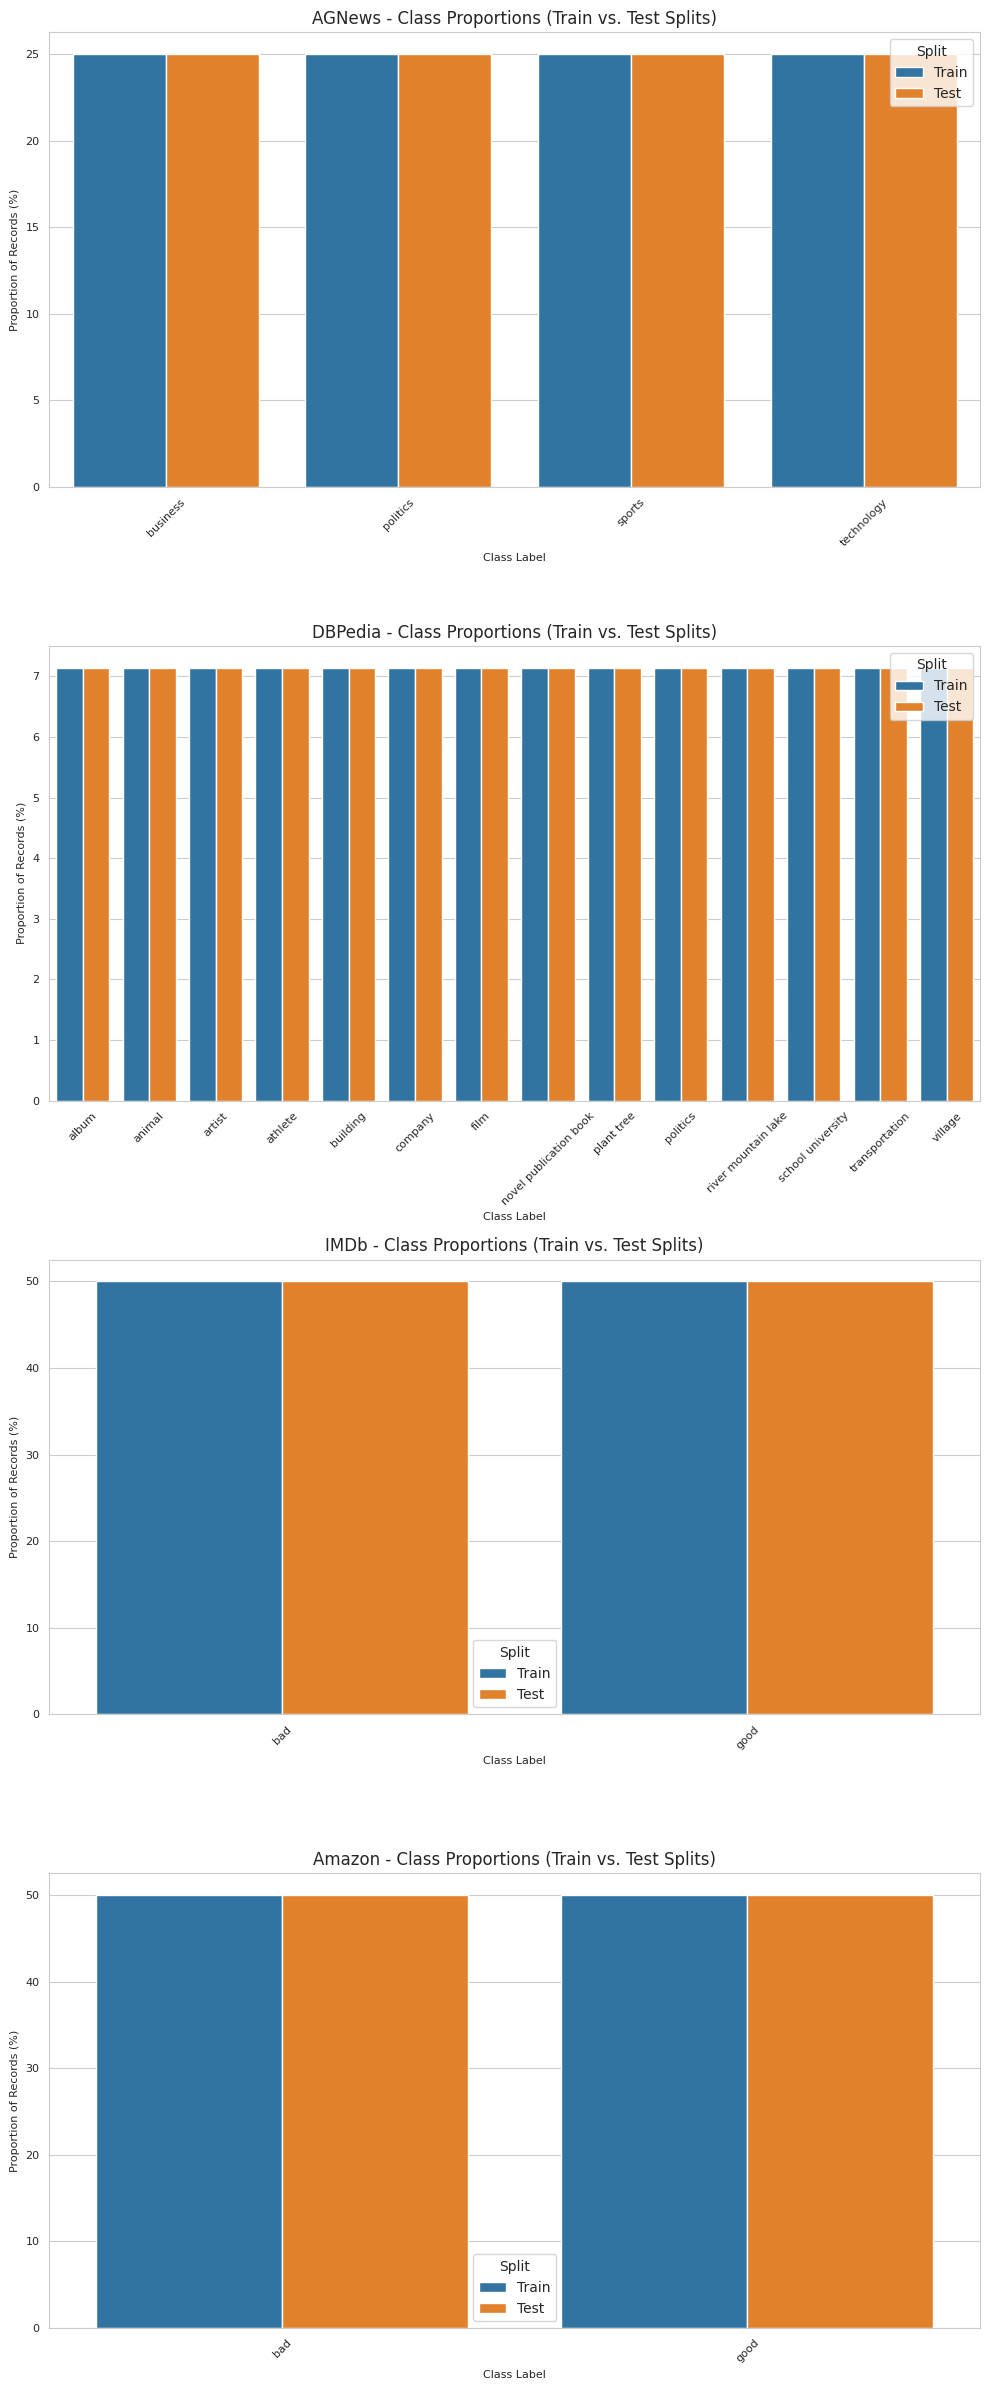

In [10]:
comparison_data = []
for name, data in datasets_data.items():
    n_train = len(data['train'])
    n_test = len(data['test'])

    train_counts = data['train']['label_name'].value_counts()
    test_counts = data['test']['label_name'].value_counts()

    all_labels = sorted(list(set(data['labels']) | set(train_counts.index) | set(test_counts.index)))

    for label in all_labels:
        train_prop = (train_counts.get(label, 0) / n_train) * 100 if n_train > 0 else 0
        test_prop = (test_counts.get(label, 0) / n_test) * 100 if n_test > 0 else 0
        comparison_data.append({'Dataset': name, 'Class': label, 'Set': 'Train', 'Proportion': train_prop})
        comparison_data.append({'Dataset': name, 'Class': label, 'Set': 'Test', 'Proportion': test_prop})

# Visualization for Train/Test Proportions
if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)

    # Create a plot for each dataset
    unique_datasets = comparison_df['Dataset'].unique()
    num_datasets = len(unique_datasets)

    fig, axes = plt.subplots(num_datasets, 1, figsize=(10, 6 * num_datasets), sharex=False) # Don't share x-axis
    if num_datasets == 1: # Handle case of single dataset
        axes = [axes]

    for ax, dataset_name in zip(axes, unique_datasets):
        data_subset = comparison_df[comparison_df['Dataset'] == dataset_name]
        class_order = sorted(data_subset['Class'].unique())
        sns.barplot(x='Class', y='Proportion', hue='Set', data=data_subset, order=class_order, ax=ax)
        ax.set_title(f'{dataset_name} - Class Proportions (Train vs. Test Splits)')
        ax.set_ylabel('Proportion of Records (%)')
        ax.set_xlabel('Class Label')
        ax.tick_params(axis='x', rotation=45) # Rotate labels if needed
        ax.legend(title='Split')

    plt.tight_layout()
    plt.show()

### 5.1 Observations
The distribution of categories is very consistent between the training and testing splits on all four datasets.